# Tropical Cyclones tracking script
**Before you start:**

1. First, make sure this notebook is opened with the bash kernel!! (If you don't have it, see instructions in `TE_intro.ipynb`)

2. Also, make sure you have installed TempestExtremes with instructions from `TE_intro.ipynb`.

3. Check the units of your data: below we assume that psl is in Pa, zg is in m, pressure levels are in hPa.  If it is not the case, adapt the code accordingly. You may also need to adjust variable names.

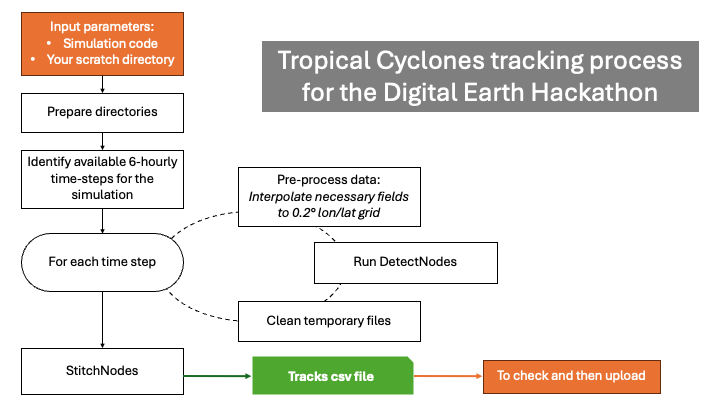

Launching the following script should perform the whole tracking for your simulation.

However, this computation might be too long/too heavy for whatever you are running this notebook on. In that case, you might need to convert it into a batch script. You can do this with `jupyter nbconvert --to script full_tracking.ipynb`.

Note: If your notebook/kernel/job is killed, re-launching it should re-start where it stopped, as the loop will not take into account time step for which nodes have already been computed.

In [ ]:
# Activate your conda environment which must include tempestextremes + the hackathon packages such as intake, easygems etc.
conda activate hackathon
# If you have a message saying you need to initalize conda: 
## create a new cell with the `conda init` command
## Run that cell
## Delete the cell
## Restart your kernel
## Run the notebook again

In [ ]:
# Script Parameters
run='um_glm_n1280_GAL9' # Code of your simulation (must be the reference in the catalog)
scr_dir='/work/scratch-nopw2/sbourdin/' # Change to your own scratch/temporary folder

In [ ]:
# 0. Prepare working directories
if ! [ -d ${scr_dir}/$run ]; then mkdir ${scr_dir}/$run; fi # Create run scr dir if does not exist
data_pp_dir=$scr_dir/$run/data_pp # dir to store preprocessed (pp) files
if ! [ -d ${data_pp_dir} ]; then mkdir ${$data_pp_dir}; fi # Create pp dir if does not exist
nodes_dir=$scr_dir/$run/nodes # dir to store nodes files
if ! [ -d ${nodes_dir} ]; then mkdir ${$nodes_dir}; fi # Create nodes dir if does not exist
tracks_dir=../TC_tracks/
timelist_file=$scr_dir/$run/timelist.txt

In [ ]:
# 1. Get the list of time steps available
python << EOF
import intake
cat = intake.open_catalog('https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml')['online']
run = "$run"
ds_1h_2d = cat[run](zoom=9, time='PT1H').to_dask()
L = [t[0:13] for t in ds_1h_2d.time.values[::6].astype(str)]
with open("$timelist_file", 'w') as f:
    for line in L:
        f.write(f"{line}\n")
EOF

In [ ]:
# 2. Detect TCs in each time steps

for ts in `cat $timelist_file` # Loop over existing time steps for this simulation
do
    nodes_file=$nodes_dir/$ts.dat
    if ! [ -f $nodes_file ] # If file does not already exists
    then
        echo "-------" $ts "-------"
        # 2a. Pre-process files
        ## Create output directory if it does not exist yet
        echo "... Pre-processing files ..."
        ## Python script to pre-process data over that time step
        python << EOF
run="$run"
t="$ts"
output_dir="${data_pp_dir}"
import intake, os
import numpy as np
import xarray as xr
import healpix as hp
import easygems.healpix as egh
# Deactivate warnings
import warnings
warnings.filterwarnings("ignore")
# Load catalogue
cat = intake.open_catalog('https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml')['online']
# Select zoom level, variables and levels
zoom = 9
variables_1h_2d = ['psl','uas','vas']   # TempestExtremes tracking is psl-based, with surface wind maxima added to tracks
variables_3h_3d = ['zg']   # zg is used by TempestExtremes for warm-core detection and (later, optionally) computing cyclone phase-space parameters (see Stella Bourdin's code)
plevc = np.array([500,250])
# Load data
ds_1h_2d = cat[run](zoom=zoom, time='PT1H').to_dask()#.pipe(egh.attach_coords)
ds_3h_3d = cat[run](zoom=zoom, time='PT3H').to_dask()#.pipe(egh.attach_coords)
# Set up grid
# Find the HEALPix pixels that are closest to, for example, the .2x.2 degree grid points.
# N.B. A 1x1 has lines at lon=90, 180, 270 (need to avoid these).
lon = np.linspace(0, 360, 1800)
lat = np.linspace(90, -90, 900)
pix = xr.DataArray(
    hp.ang2pix(ds_1h_2d.crs.healpix_nside, *np.meshgrid(lon, lat), nest=True, lonlat=True),
    coords=(("lat", lat), ("lon", lon)))
## Pre-process data
for var in variables_1h_2d:
    output_fn = '_'.join([run,var,str(t)[:13]])+'.nc'
    output_ffp = os.path.join(output_dir,output_fn)
    d = ds_1h_2d[var].sel(time=t).isel(cell=pix)
    d.to_netcdf(output_ffp)
for var in variables_3h_3d:
    d = ds_3h_3d[var].sel(time=t,pressure=plevc).isel(cell=pix)
    for p in d.pressure:
        d_p = d.sel(pressure=p).squeeze()
        d_p = d_p.rename("zg"+str(p.values))
        output_fn = '_'.join([run,"zg"+str(p.values),str(t)[:13]])+'.nc'
        output_ffp = os.path.join(output_dir,output_fn)
        d_p.to_netcdf(output_ffp)
EOF

        # 2b. Run DetectNodes
        echo "... DetectNodes ..."
        ## Prepare file list
        flist=`ls $data_pp_dir/*$ts*`
        INPUT=""
        for f in $flist
        do
        INPUT="$INPUT$f;"
        done
        INPUT=${INPUT:0:-1} # Remove last ;
    
        ## DetectNodes
        DetectNodes \
            --in_data $INPUT \
            --out $nodes_file \
            --searchbymin "psl" \
            --closedcontourcmd "psl,200.0,5.5,0;_DIFF(zg250,zg500),-6,6.5,1.0" \
            --mergedist 6.0 \
            --outputcmd "psl,min,0;_VECMAG(uas,vas),max,2" >> $scr_dir/DN_log.txt
        
        # 2c. Clean temporary files
        rm $data_pp_dir/*$ts*
        echo "... Done ..."
        
    else # If nodes already exist for this time step
        echo "$ts already computed"
    fi
    
done

In [ ]:
# 3. StitchNodes
## Prepare list of nodesfiles
flist=`ls $nodes_dir/2*`
cat $flist > $nodes_dir/all_nodes.dat
## StitchNodes
StitchNodes \
--in $nodes_dir/all_nodes.dat \
--out $tracks_dir/$run.csv \
--out_file_format "csv" \
--in_fmt "lon,lat,slp,wind" \
--range 8.0 \
--mintime "54h" \
--maxgap "24h" \
--threshold "wind,>=,10.0,10;lat,<=,50.0,10;lat,>=,-50.0,10"
# NB: Double-check that the output does not mention gaps in the data
# Check that the period covered is the one you expect

In [ ]:
#4. Check tracks
python << EOF
# Deactivate warnings
import warnings
warnings.filterwarnings("ignore")
# Plot tracks
import huracanpy
import matplotlib.pyplot as plt
tracks = huracanpy.load("$tracks_dir/$run.csv")
tracks.hrcn.plot_tracks()
plt.savefig("check_$run.png")
EOF